In [1]:
!pip install numpy==1.23.5 --no-deps --force-reinstall

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [1]:
pip install batman-package

In [2]:
pip install emcee

In [3]:
pip install corner

In [4]:
pip install lightkurve

In [5]:
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import batman
from scipy.optimize import minimize
import emcee
from IPython.display import display, Math
import corner

In [6]:
# Option 1 - Upload Light Curve txt File from Classification Notebook
uploaded = files.upload()

In [7]:
# Read in uploaded file
file_name = 'object_parameters.txt'
df = pd.read_csv(file_name, sep="\t", comment='#')

time = df['Time:'].values
flux = df['Flux'].values
tic_id = df['TIC_ID'].iloc[0]
period = df['Period [days]'].iloc[0]
print(f"TIC ID: {tic_id}")
print(f"Period: {period} days")

TIC ID: 457104362
Period: 4.816 days


In [201]:
# Option 2 - Input TIC ID and period
tic_id = input("Enter TIC ID: ")
period = float(input("Enter period in days: "))

Enter TIC ID: 457104362
Enter period in days: 4.816


In [185]:
# Function to get TESS LC

def find_and_plot_LC_Input(tess_id, period):
    all_time = []
    all_flux = []

    search_result = lk.search_lightcurve(f"TIC {tess_id}")
    for result in search_result:
        try:
            lcf =result.download()
            if lcf is None or lcf.flux is None:
                continue
            time= lcf.time.value
            flux = lcf.flux.value
            if np.any(np.isnan(time)) or np.any(np.isnan(flux)):
                continue
            median_flux = np.nanmedian(flux)
            norm_flux = flux/median_flux
            all_time.append(time)
            all_flux.append(norm_flux)
        except Exception as e:
            print(f"Skipping- A sector due to error: {e}")
            continue
    if len(all_time)==0:
        raise ValueError("Skipping -No valid light curve segments found.")
    combined_time = np.concatenate(all_time)
    combined_flux = np.concatenate(all_flux)
    clean_lc = lk.LightCurve(time=combined_time, flux=combined_flux)
    folded = clean_lc.fold(period=period, epoch_time=1367.2755)
    folded.bin(time_bin_size=0.025).plot(label=f"TIC {tess_id}")
    cleaned = folded.remove_outliers(sigma=3)
    return cleaned.time.value, cleaned.flux.value

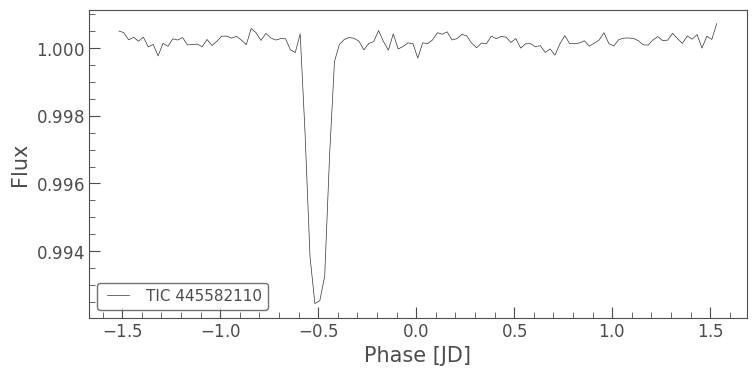

In [164]:
# Get light curve from TESS (if not uploaded)

time,flux = find_and_plot_LC_Input(tic_id, period)

In [8]:
# Bin the data to reduce computation time and noise

bin_size = 5
num_bins = int(np.ceil(len(time) / bin_size))

binned_time = np.zeros(num_bins)
binned_flux = np.zeros(num_bins)

for i in range(num_bins):
  start_index = i * bin_size
  end_index = min((i + 1) * bin_size, len(time))
  binned_time[i] = np.mean(time[start_index:end_index])
  binned_flux[i] = np.mean(flux[start_index:end_index])


In [31]:
# Set time, flux, initial guess, and priors used for the MCMC

timex = np.linspace(-1,1,len(binned_time))
flux = binned_flux
flux_err = np.std(binned_flux)

t0_guess = timex[np.argmin(flux)] # Center of Transit
rp_guess = np.sqrt(1-np.min(flux)) # Planet Radius (R_planet / R_star)
a_guess = 30 # Semi major axis of orbit

guess = np.array([rp_guess,a_guess,t0_guess])
priors = [rp_guess*2,rp_guess*0.5,a_guess*2,a_guess/5,t0_guess+1,t0_guess-1] #[rp_upper,rp_lower,a_upper,a_lower]

In [32]:
def f_batman(x, rp, a,t0 ,per = period,inc = 90,ecc=0.00,w=90,baseline=0.0,u=[0,0],limb_dark='quadratic'):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0          #time of inferior conjunction
    params.per = per                  #orbital period
    params.rp =  rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                     #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = u                #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline        #calculates light curve

def log_likelihood(theta, x, y, yerr):
    #   theta = [rp , a , t0] same order as the guess array is organized
    batman_model = f_batman(x, theta[0],theta[1],theta[2])

    model = batman_model
    residuals = (flux - model)
    lnlike = -0.5 * np.sum((residuals / flux_err)**2 + np.log(2 * np.pi * flux_err**2))
    return lnlike

In [33]:
# Minimization fit to find best starting parameters
args=(timex, flux,flux_err)
nll = lambda *args: -log_likelihood(*args)
solnw = minimize(nll, guess, args )

labels = ["rp","a","t0"] # same order as guess array

print('The minimization fits are:')
for idx in range(len(solnw.x)):
    print("{} : {} ({})".format(labels[idx], solnw.x[idx], guess[idx]))

The minimization fits are:
rp : 0.10935290187902162 (0.13347778841440247)
a : 36.607712538038534 (30.0)
t0 : -0.3133389814101656 (-0.32034590896132276)


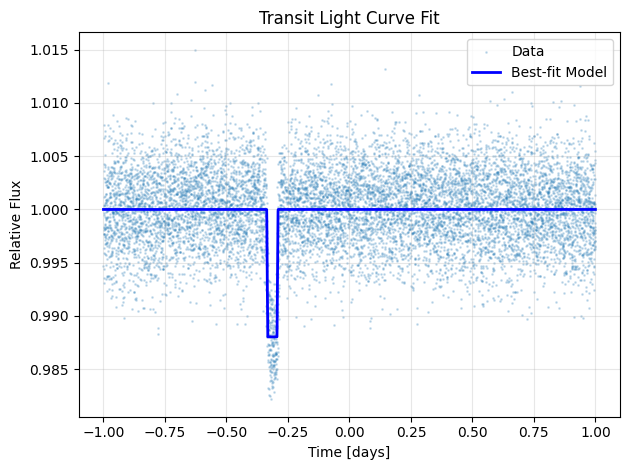

In [34]:
# Check the minimization fit

rp_fit, a_fit ,t0_fit= solnw.x
best_model_flux = f_batman(timex, rp_fit, a_fit,t0_fit)

plt.scatter(timex, flux, s=1,alpha=0.2, label='Data')
plt.plot(timex, best_model_flux, color='blue', lw=2, label='Best-fit Model')
plt.xlabel("Time [days]")
plt.ylabel("Relative Flux")
plt.title("Transit Light Curve Fit")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# Define priora and log-probability function for MCMC

def log_prior(theta):
    # We're using only uniform priors:,
    if theta[0] > priors[0] or theta[0] < priors[1]: #fp
        return -np.inf
    if theta[1] > priors[2] or theta[1] < priors[3]: #a or r1
        return -np.inf
    if theta[2] > priors[4] or theta[2] < priors[5]: #b or r2
        return -np.inf
    return 0.0

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
print("arrived")

arrived


In [37]:
# Run the MCMC + model fit for your light curve!

ndim = len(solnw.x) # Number of parameters being fit
nwalkers = ndim*5  # Number of walkers. It is recommended to be at least higher than twice the amount of parameters being fit
nsteps = 10000 # Number of steps
nburn = 2000 # Number of steps to burn from beginning

order_of_mag = np.array([0.01,0.1,0.01]) #Same order as the guess array, have one number for each parameter

pos = solnw.x + order_of_mag * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(timex, flux, flux_err))
p,pr,s=sampler.run_mcmc(pos, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=nburn, thin=20, flat=True)

for i in range(ndim):
    mcmcw = np.percentile(flat_samples[:, i], [16, 50, 84])
    qw = np.diff(mcmcw)
    if i == 0:
        rp_fit_mc = np.array(mcmcw[1]) # Saves the a and b values fit for the white to use in spectroscopic fits
    if i == 1:
        a_fit_mc = np.array(mcmcw[1]) # Saves the a and b values fit for the white to use in spectroscopic fits
    if i == 2:
        t0_fit_mc = np.array(mcmcw[1])
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmcw[1], qw[0], qw[1], labels[i])
    display(Math(txt))

100%|██████████| 10000/10000 [02:48<00:00, 59.26it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

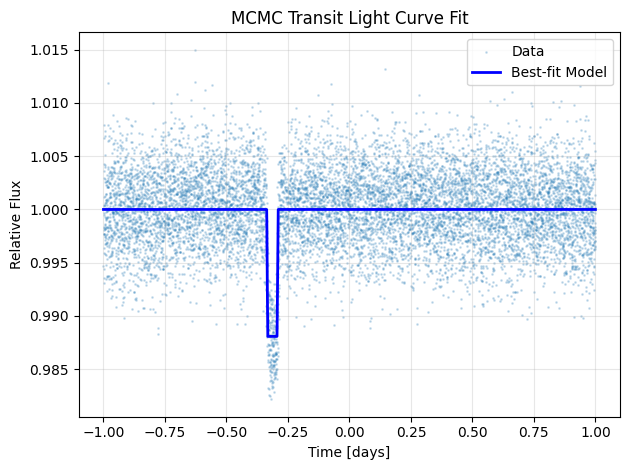

In [38]:
# Plot the fit model

best_model_flux = f_batman(timex, rp_fit_mc, a_fit_mc,t0_fit_mc)

plt.scatter(timex, flux, s=1,alpha =0.2, label='Data')
plt.plot(timex, best_model_flux, color='blue', lw=2, label='Best-fit Model')
plt.xlabel("Time [days]")
plt.ylabel("Relative Flux")
plt.title("MCMC Transit Light Curve Fit")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

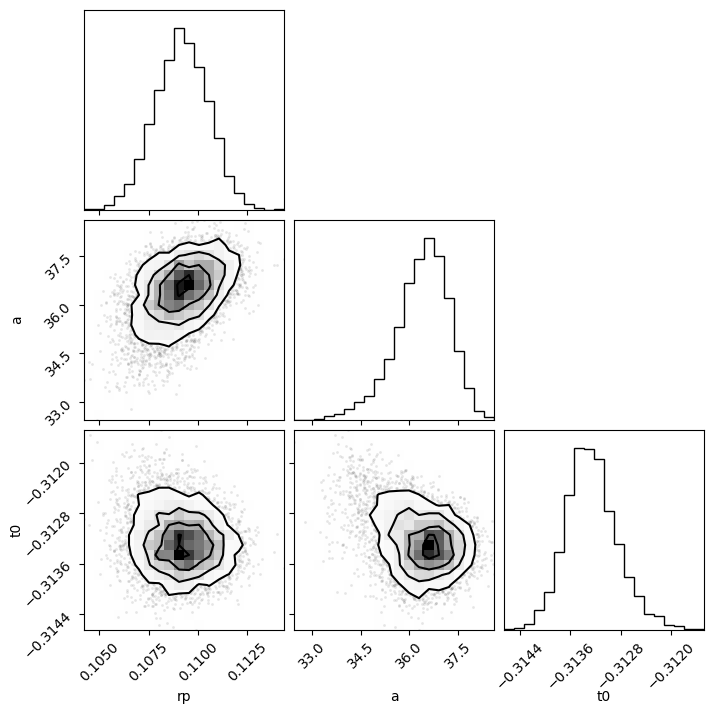

In [39]:
# Show the corner plot from MCMC run
flat_samples = sampler.get_chain(discard=nburn, thin=20, flat=True)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    if i == 0:
        rpw = mcmc[1]
    if i == 2:
        aw = mcmc[1]
    if i == 3:
        t0w = mcmc[1]
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

fig = corner.corner(flat_samples, labels=labels)